Multicollinearity and Principle Component Analysis (PCA)

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from factor_analyzer import FactorAnalyzer, calculate_kmo
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from spotpython.surrogate.kriging import Kriging
from spotpython.utils.pca import pca_analysis
from spotpython.utils.stats import compute_coefficients_table, condition_index

1. Exploratory Data Analysis (EDA)


In [2]:
df = pd.read_csv("C:\\Semester 2\\ML&AI\\car_sales_subset_3.csv", encoding="utf-8")
print(df.shape)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Semester 2\\ML&AI\\car_sales_subset_3.csv'

In [ ]:
# Remove the first column (assuming it is an index or non-informative)
df = df.drop(df.columns[0], axis=1)
# print the column names
print(df.columns)

Index(['manufact', 'model', 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales', 'zresale', 'ztype', 'zprice', 'zengine_', 'zhorsepo',
       'zwheelba', 'zwidth', 'zlength', 'zcurb_wg', 'zfuel_ca', 'zmpg'],
      dtype='object')


Missing values per column:
manufact     0
model        0
sales        0
resale      18
type         0
price        0
engine_s     0
horsepow     0
wheelbas     0
width        0
length       0
curb_wgt     1
fuel_cap     0
mpg          2
lnsales      0
zresale     18
ztype        0
zprice       0
zengine_     0
zhorsepo     0
zwheelba     0
zwidth       0
zlength      0
zcurb_wg     1
zfuel_ca     0
zmpg         2
ln_sales     0
dtype: int64


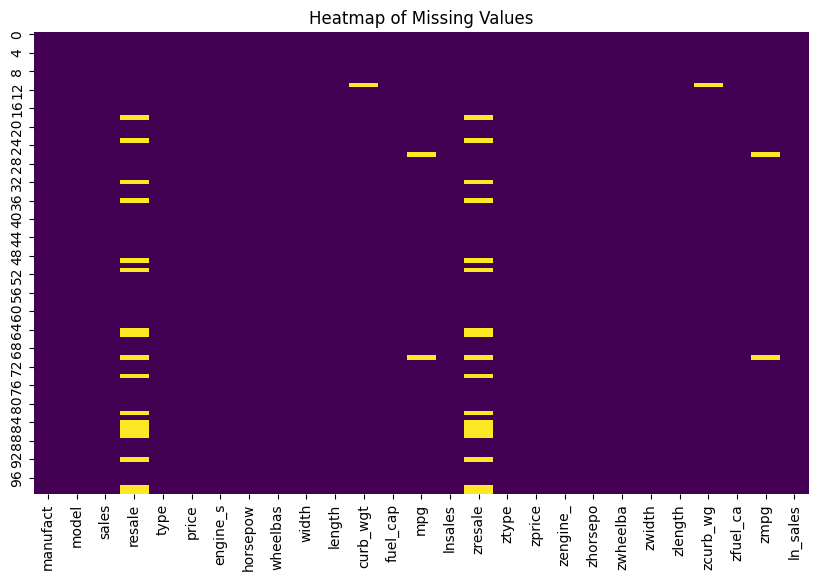

In [ ]:
# Count missing values in each column
print("Missing values per column:")
print(df.isnull().sum())

# Visualizing missing values using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values")
plt.show()


Car type distribution:
type
0    80
1    20
Name: count, dtype: int64


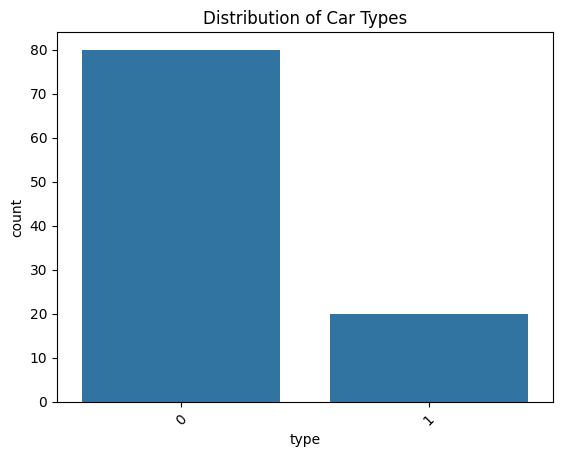

In [ ]:
# Frequency of each car type
print("Car type distribution:")
print(df['type'].value_counts())

# Optional: Plot car type distribution
sns.countplot(data=df, x='type')
plt.title("Distribution of Car Types")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Summary statistics for all numeric columns
df.describe()


,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,...,zprice,zengine_,zhorsepo,zwheelba,zwidth,zlength,zcurb_wg,zfuel_ca,zmpg,ln_sales
count,100.000000,82.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000,100.000000,98.000000,100.000000
mean,54.858190,18.968963,0.200000,27.136260,3.094000,188.190000,107.275000,71.410000,188.013000,3.325970,...,-0.017733,0.031688,0.039529,-0.027767,0.075321,0.049838,-0.082563,-0.062996,0.021768,3.309703
std,60.800874,12.392298,0.402015,14.250606,1.061714,60.087259,7.570936,3.320201,13.670943,0.538868,...,0.992959,1.016332,1.059734,0.990791,0.961855,1.017808,0.854666,0.931386,0.881748,1.410059
min,0.110000,7.750000,0.000000,11.528000,1.600000,100.000000,92.600000,66.400000,152.000000,2.339000,...,-1.105291,-1.398452,-1.515842,-1.948251,-1.376065,-2.631346,-1.647935,-1.556596,-2.064928,-2.207275
25%,12.994500,12.087500,0.000000,17.513500,2.300000,141.500000,102.900000,68.900000,177.475000,2.921500,...,-0.688231,-0.728373,-0.783924,-0.600314,-0.651820,-0.734721,-0.724068,-0.534199,-0.430452,2.562482
50%,32.754500,13.950000,0.000000,22.436500,3.000000,187.500000,106.700000,70.750000,189.000000,3.332000,...,-0.345204,-0.058294,0.027359,-0.103016,-0.115879,0.123320,-0.072999,-0.244841,0.036541,3.489040
75%,76.988750,20.441250,0.000000,31.938750,3.800000,215.000000,112.200000,74.025000,196.625000,3.590500,...,0.316897,0.707510,0.512365,0.616756,0.832881,0.691005,0.336992,0.269573,0.503534,4.343432
max,276.747000,67.550000,1.000000,82.600000,8.000000,450.000000,138.700000,79.300000,224.200000,5.115000,...,3.846891,4.727984,4.656963,4.084751,2.361038,2.743976,2.754908,3.613262,2.138009,5.623104


In [ ]:
df['ln_sales'] = np.log(df['sales'].replace(0, np.nan))
if df['ln_sales'].isnull().any() or np.isinf(df['ln_sales']).any():
    df['ln_sales'] = df['ln_sales'].fillna(df['ln_sales'].median())  # Or any other strategy
y = df['ln_sales']

In [ ]:
# Use columns from 'price' to 'mpg' as predictors
independent_var_columns = ['price', 'engine_s', 'horsepow', 'wheelbas', 
                           'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg','resale']

# Select those columns, ensuring they are numeric
X = df[independent_var_columns].apply(pd.to_numeric, errors='coerce')

# Handle missing/nans in features by using an appropriate imputation strategy
X = X.fillna(X.median())  # Impute with median or any other appropriate strategy
# Display the first few rows of the features
X.head()

,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,resale
0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,29.725
1,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,22.255
2,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,23.555
3,62.00,4.2,310.0,113.0,74.0,198.2,3.902,23.7,21.0,39.000
4,33.40,2.8,193.0,107.3,68.5,176.0,3.197,16.6,24.0,28.675


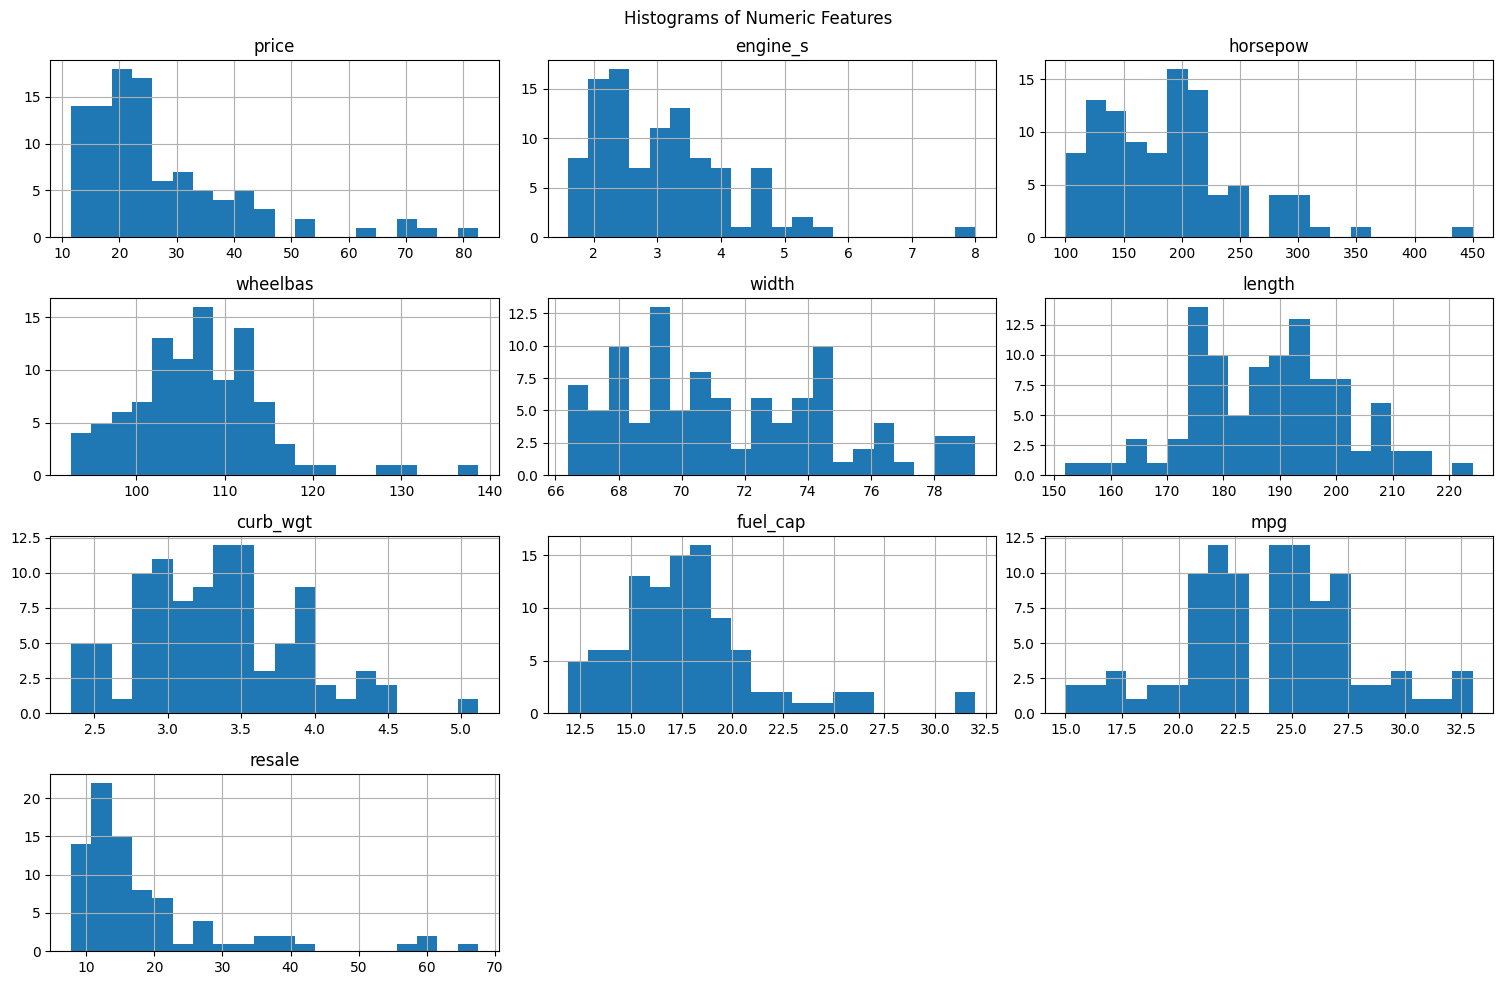

In [ ]:
df[independent_var_columns].hist(figsize=(15, 10), bins=20)
plt.suptitle("Histograms of Numeric Features")
plt.tight_layout()
plt.show()


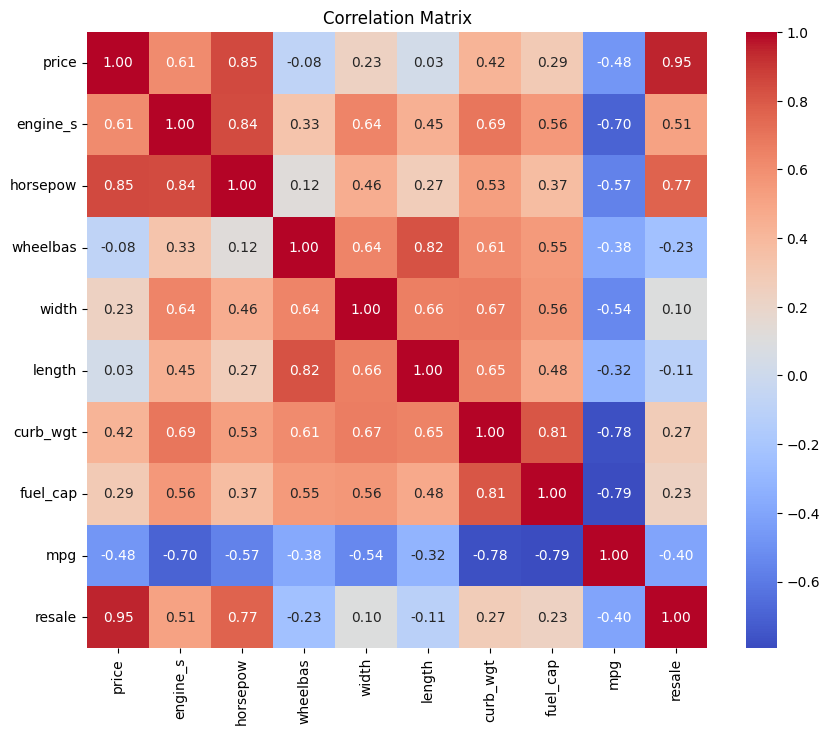

In [ ]:
# Compute correlations
corr_matrix = df[independent_var_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


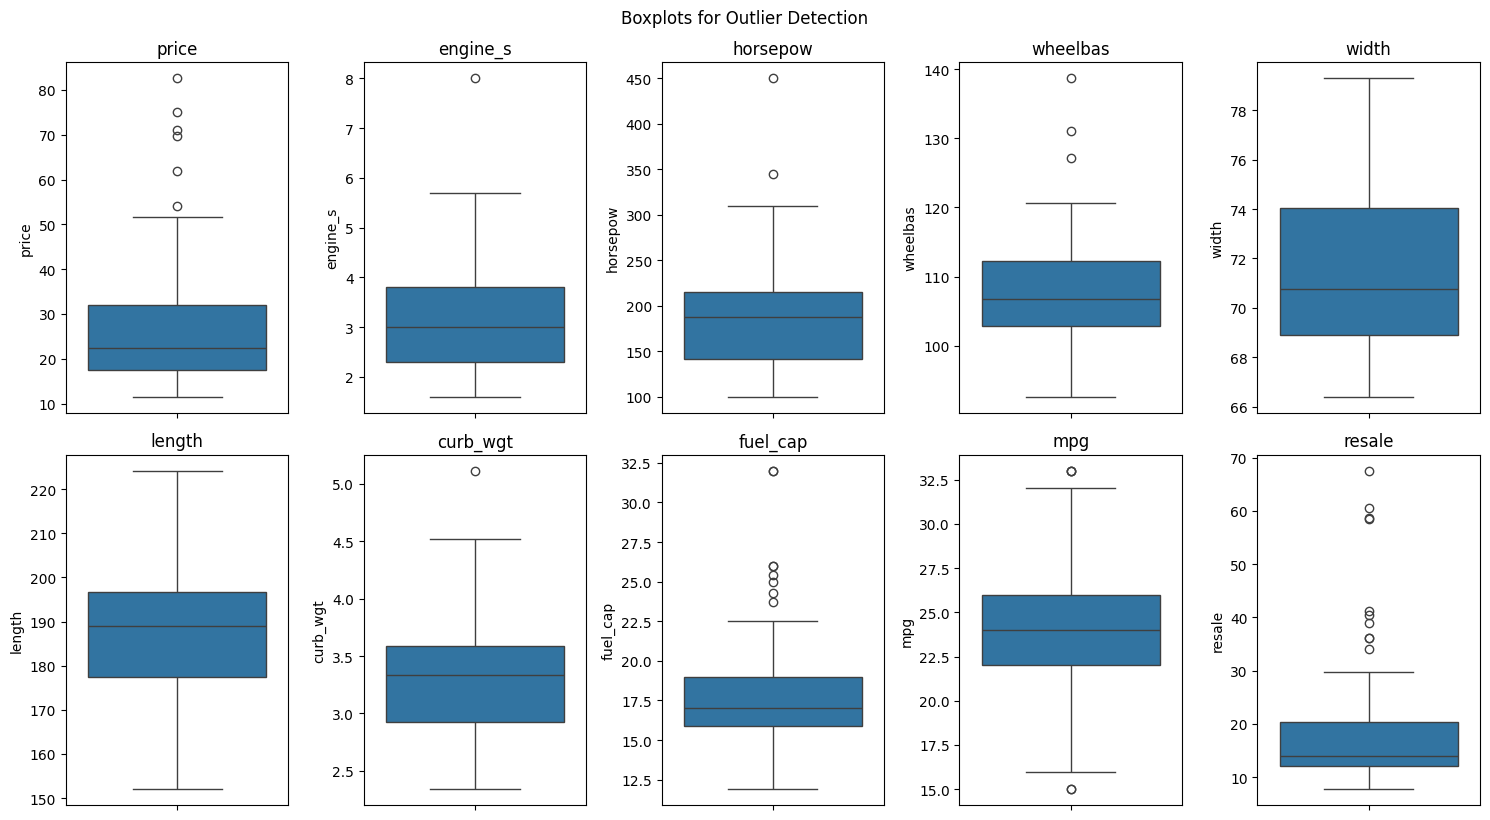

In [ ]:
# Boxplots to visually detect outliers
plt.figure(figsize=(15, 8))
for i, col in enumerate(independent_var_columns):
    plt.subplot(2, 5, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.suptitle("Boxplots for Outlier Detection", y=1.02)
plt.show()


In [ ]:
if X.isnull().any().any():
    print("NaNs detected in X. Filling with column medians.")
    X = X.fillna(X.median())

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
if np.isnan(X_scaled).any() or np.isinf(X_scaled).any():
    raise ValueError("X_scaled contains NaN or infinite values after preprocessing.")
# Convert the scaled data back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# Display the first few rows of the scaled features
X_scaled.head()

,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,resale
0,1.048280,0.384327,0.364801,0.972390,-0.003027,0.631285,0.982224,0.081321,-0.521078,1.030121
1,-0.221893,-1.224924,-0.638778,-0.620604,-0.971679,-0.736119,-0.614919,-0.362753,0.823292,0.370141
2,0.480546,-0.278306,0.197538,0.189168,1.419681,0.293110,0.440470,0.220094,-0.521078,0.484997
3,2.458799,1.046960,2.037431,0.759991,0.784003,0.748911,1.079702,1.663333,-0.789952,1.849574
4,0.441756,-0.278306,0.080454,0.003319,-0.880868,-0.883152,-0.241877,-0.307243,0.016670,0.937353


In [ ]:
top_5_manufact = df['manufact'].value_counts().nlargest(3).index
df['manufact_limited'] = df['manufact'].apply(lambda x: x if x in top_5_manufact else 'Other')

# Step 2: Define new categorical columns
categorical_cols = ['type', 'manufact_limited']# Replace if more categorical variables exist
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_categorical_encoded = encoder.fit_transform(df[categorical_cols])
# Convert encoded data into a DataFrame
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded,
                                        columns=encoder.get_feature_names_out(categorical_cols))
X_categorical_encoded_df.describe(include='all')

,type_1,manufact_limited_Ford,manufact_limited_Other,manufact_limited_Toyota
count,100.000000,100.000000,100.000000,100.000000
mean,0.200000,0.070000,0.760000,0.070000
std,0.402015,0.256432,0.429235,0.256432
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [ ]:
X_encoded = pd.concat([X_scaled, X_categorical_encoded_df], axis=1)
X_encoded.describe(include='all')

,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,resale,type_1,manufact_limited_Ford,manufact_limited_Other,manufact_limited_Toyota
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,100.000000
mean,-2.703393e-16,1.221245e-16,3.885781e-17,3.057554e-15,1.112443e-15,3.744782e-15,-4.463097e-16,-2.131628e-16,-6.544765e-16,-1.854072e-16,0.200000,0.070000,0.760000,0.070000
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,0.402015,0.256432,0.429235,0.256432
min,-1.100788e+00,-1.414248e+00,-1.475093e+00,-1.948099e+00,-1.516546e+00,-2.647544e+00,-1.850267e+00,-1.611710e+00,-2.403196e+00,-9.113865e-01,0.000000,0.000000,0.000000,0.000000
25%,-6.786545e-01,-7.516150e-01,-7.809512e-01,-5.807790e-01,-7.597867e-01,-7.747153e-01,-7.484826e-01,-5.084643e-01,-5.210778e-01,-4.713998e-01,0.000000,0.000000,1.000000,0.000000
50%,-3.314551e-01,-8.898212e-02,-1.154115e-02,-7.633096e-02,-1.997846e-01,7.256064e-02,1.119125e-02,-1.962251e-01,1.667019e-02,-3.636119e-01,0.000000,0.000000,1.000000,0.000000
75%,3.387003e-01,6.683125e-01,4.484322e-01,6.537912e-01,7.915706e-01,6.331228e-01,4.953017e-01,3.588670e-01,5.544182e-01,1.215441e-01,0.000000,0.000000,1.000000,0.000000
max,3.911634e+00,4.644110e+00,4.379114e+00,4.171653e+00,2.388334e+00,2.660336e+00,3.353568e+00,3.966966e+00,2.436536e+00,4.371988e+00,1.000000,1.000000,1.000000,1.000000


Training using machine learning model :


In [ ]:
import time

X_encoded_with_const = sm.add_constant(X_encoded)  # Adds a constant term (intercept) to the model
start = time.time()
model = sm.OLS(df['ln_sales'], X_encoded_with_const).fit()
end = time.time()

print(f"Training time (Original Features): {end - start:.4f} seconds")


Training time (Original Features): 0.0169 seconds


In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_sales   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     7.645
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           3.99e-10
Time:                        10:23:55   Log-Likelihood:                -135.00
No. Observations:                 100   AIC:                             300.0
Df Residuals:                      85   BIC:                             339.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [ ]:
coeffs_table = compute_coefficients_table(
    model=model,
    X_encoded=X_encoded_with_const,
    y=y,
    vif_table=None
)
print("\nCoefficients Table:")
print(coeffs_table)


Coefficients Table:
                   Variable  Zero-Order r  Partial r  Semipartial r  \
0                     price     -0.582877  -0.217712      -0.148407   
1                  engine_s     -0.216997   0.116154       0.077806   
2                  horsepow     -0.441129   0.020793       0.013837   
3                  wheelbas      0.307442   0.107781       0.072129   
4                     width      0.000624  -0.038186      -0.025424   
5                    length      0.200744   0.016208       0.010785   
6                  curb_wgt     -0.033170   0.154558       0.104081   
7                  fuel_cap     -0.024964  -0.107224      -0.071751   
8                       mpg      0.217476   0.318559       0.223591   
9                    resale     -0.536985   0.056184       0.037439   
10                   type_1      0.322515   0.296699       0.206706   
11    manufact_limited_Ford      0.293498   0.186053       0.125984   
12   manufact_limited_Other     -0.330903  -0.030774    

In [ ]:
fa_temp = FactorAnalyzer(n_factors=X_encoded.shape[1], method="principal", rotation=None)
try:
    fa_temp.fit(X_encoded)
    ev, _ = fa_temp.get_eigenvalues()
    # sort eigenvalues in ascending order
    ev = np.sort(ev)
    print("Eigenvalues for each component:\n", ev)
except Exception as e:
    print(f"Error during factor analysis fitting: {e}")
    print("Consider reducing multicollinearity or removing problematic features.")

Eigenvalues for each component:
 [0.03559766 0.08281714 0.10985588 0.126004   0.14682763 0.21825821
 0.25757246 0.31813257 0.4408694  0.94177826 1.10113654 1.7146429
 2.94132795 5.5651794 ]


c:\Semester 2\ML&AI\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
X_cond = copy.deepcopy(X_encoded)
condition_index_df = condition_index(X_cond)
print("\nCondition Index:")
print(condition_index_df)


Condition Index:
    Index  Eigenvalue  Condition Index
0       0    0.017785        17.581587
1       1    0.031276        13.258039
2       2    0.047589        10.748120
3       3    0.070325         8.841619
4       4    0.088989         7.859942
5       5    0.128820         6.532757
6       6    0.130676         6.486194
7       7    0.182237         5.492497
8       8    0.242905         4.757397
9       9    0.294063         4.323818
10     10    0.442921         3.523095
11     11    0.876560         2.504360
12     12    2.526612         1.475089
13     13    5.497626         1.000000


In [ ]:
kmo_all, kmo_model = calculate_kmo(X_encoded)
print(f"\nKMO measure: {kmo_model:.3f} (0.6+ is often considered acceptable)")


KMO measure: 0.733 (0.6+ is often considered acceptable)


c:\Semester 2\ML&AI\.venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


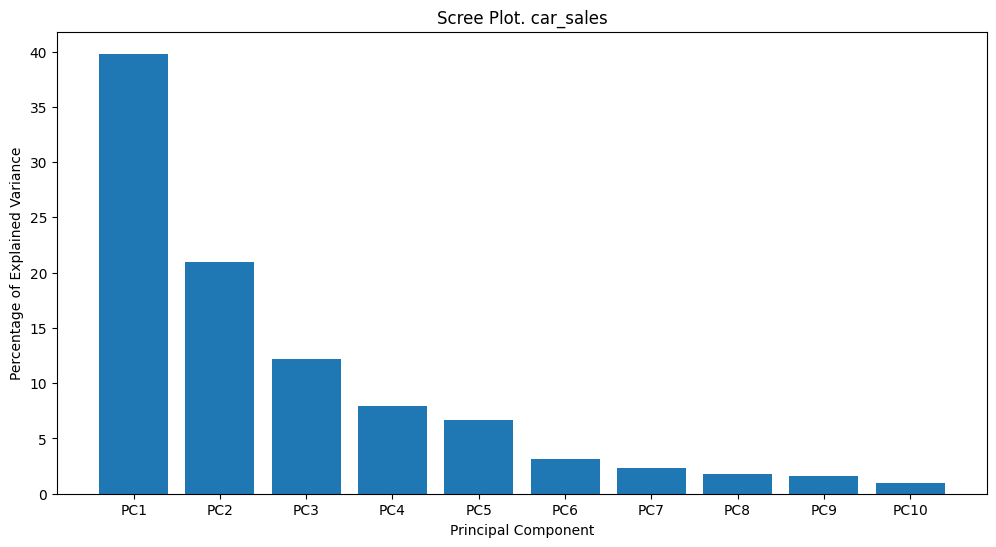

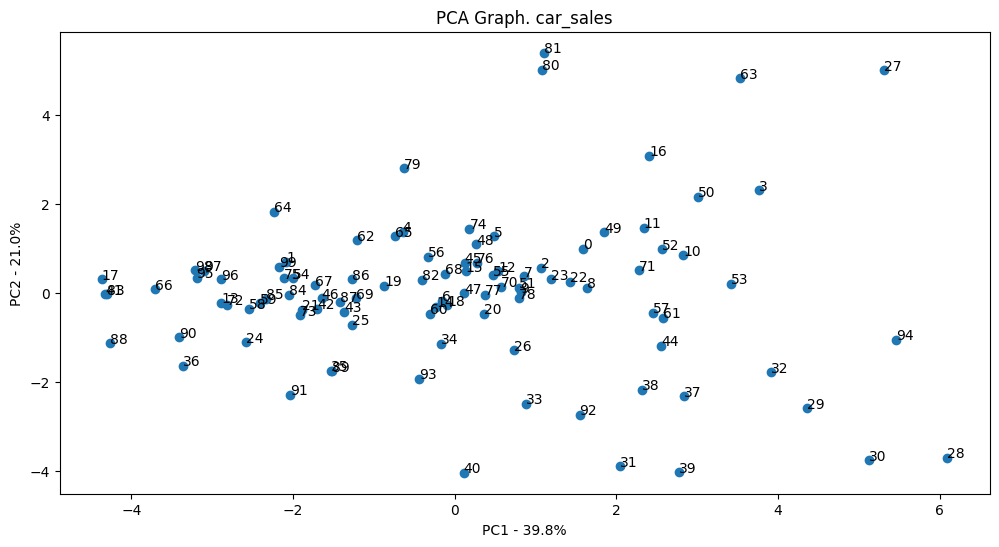

In [ ]:
top_features = pca_analysis(df=X_encoded, df_name="car_sales", k=10, scaler=StandardScaler(), max_scree=10)

In [ ]:
anz_fak = 10
n_factors = min(anz_fak, X_encoded.shape[1])
fa = FactorAnalyzer(n_factors=n_factors, method="principal", rotation="varimax")
fa.fit(X_encoded)
# Factor loadings
factor_loadings = fa.loadings_
actual_factors = factor_loadings.shape[1]  # Number of factors actually extracted
print(f"actual_factors: {actual_factors}")
if actual_factors < n_factors:
    print(
        f"\nWarning: Only {actual_factors} factors could be extracted "
        f"(requested {n_factors})."
    )
factor_columns = [f"Factor{i+1}" for i in range(actual_factors)]

actual_factors: 10


c:\Semester 2\ML&AI\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Print factor loadings with 2 decimals
print("Factor Loadings (rounded to 2 decimals):\n", np.round(factor_loadings, 2))

Factor Loadings (rounded to 2 decimals):
 [[ 0.19  0.95 -0.08 -0.05 -0.02  0.04 -0.1  -0.02  0.12  0.1 ]
 [ 0.37  0.51  0.02  0.04 -0.05  0.23  0.03  0.28 -0.06  0.66]
 [ 0.19  0.78 -0.07 -0.06 -0.07  0.13 -0.1   0.16  0.02  0.49]
 [ 0.23 -0.11  0.18  0.04 -0.04  0.14 -0.19  0.9  -0.14 -0.01]
 [ 0.31  0.15 -0.01  0.01 -0.07  0.75 -0.01  0.52 -0.08  0.19]
 [ 0.2  -0.   -0.09  0.05 -0.02  0.12  0.15  0.92  0.03  0.15]
 [ 0.68  0.28  0.18  0.01  0.05  0.18  0.03  0.52  0.2   0.18]
 [ 0.83  0.19  0.21  0.01  0.01  0.1   0.14  0.35 -0.19  0.02]
 [-0.78 -0.34 -0.26 -0.04  0.06 -0.15  0.23 -0.15  0.07 -0.24]
 [ 0.11  0.96 -0.01 -0.06 -0.02  0.01  0.14 -0.12 -0.04 -0.04]
 [ 0.43 -0.14  0.86  0.09  0.17 -0.01 -0.01  0.07 -0.13 -0.01]
 [ 0.01 -0.08  0.05  0.98 -0.05  0.   -0.    0.05 -0.13  0.  ]
 [-0.17  0.11 -0.22 -0.41 -0.43 -0.09  0.01 -0.12  0.71 -0.04]
 [-0.02 -0.04  0.1  -0.05  0.98 -0.04  0.   -0.06 -0.13 -0.03]]


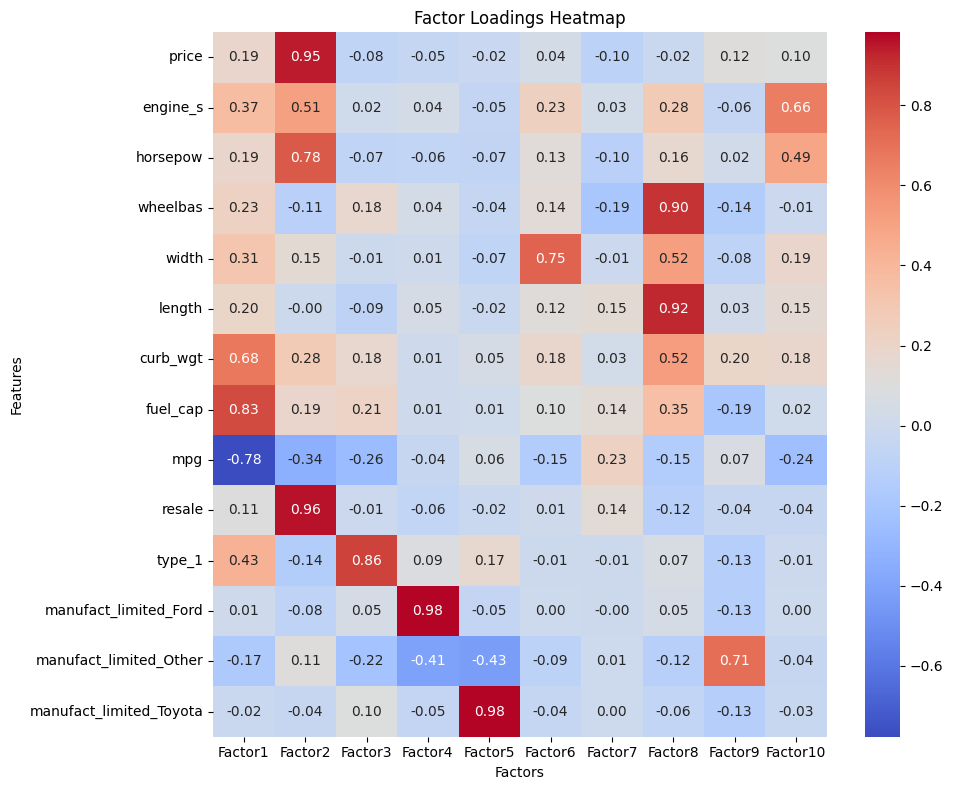

In [ ]:
# Create a DataFrame for the factor loadings
factor_loadings_df = pd.DataFrame(
    factor_loadings,
    index=X_encoded.columns,  # Original feature names
    columns=factor_columns  # Factor names
)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    factor_loadings_df,
    annot=True,  # Annotate with values
    fmt=".2f",  # Format values to 2 decimals
    cmap="coolwarm",  # Color map
    cbar=True  # Show color bar
)
plt.title("Factor Loadings Heatmap")
plt.xlabel("Factors")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [ ]:
# Factor scores for each row (shape: [n_samples, actual_factors])
X_factor_scores = fa.transform(X_encoded)
print(f"X_factor_scores shape: {X_factor_scores.shape}")

# Adapt the factor column names to the actual factor count
df_factors = pd.DataFrame(X_factor_scores, columns=factor_columns)
print(f"df_factors shape: {df_factors.shape}")
print(f"df_factors head:\n{df_factors.head()}")

X_factor_scores shape: (100, 10)
df_factors shape: (100, 10)
df_factors head:
    Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7  \
0  0.177902  1.097295 -0.363827 -0.097776 -0.075729 -0.713148 -0.955378   
1 -0.166607  0.128607 -0.318963 -0.248440 -0.354164 -0.604253  0.504705   
2  0.434542  0.408128 -0.633006 -0.146575 -0.087474  1.973317 -0.586613   
3  0.804305  2.246008 -0.730535 -0.210217 -0.167185 -0.290597 -0.175348   
4 -0.091206  0.785421 -0.189776 -0.262062 -0.388901 -0.927306 -0.974281   

    Factor8   Factor9  Factor10  
0  1.104920  0.614495 -0.846119  
1 -0.444546  0.047407 -1.410980  
2  0.053555  0.664918 -1.409739  
3  0.955234  0.032321 -0.802199  
4 -0.227414 -0.104496 -0.831358  


c:\Semester 2\ML&AI\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Applying PCA

In [ ]:
import time


X_model = sm.add_constant(df_factors)
start = time.time()
model_factors = sm.OLS(y, X_model).fit()
end = time.time()
print(f" Training time (PCA Features): {end - start:.4f} seconds")
print("\nRegression on Factor Scores:")
print(model_factors.summary())

 Training time (PCA Features): 0.0167 seconds

Regression on Factor Scores:
                            OLS Regression Results                            
Dep. Variable:               ln_sales   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     10.41
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           1.97e-11
Time:                        10:32:50   Log-Likelihood:                -137.02
No. Observations:                 100   AIC:                             296.0
Df Residuals:                      89   BIC:                             324.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [ ]:
coeffs_table = compute_coefficients_table(
    model=model_factors,
    X_encoded=X_model,
    y=y,
    vif_table=None
)
print("\nCoefficients Table:")
print(coeffs_table)


Coefficients Table:
   Variable  Zero-Order r  Partial r  Semipartial r  Tolerance  VIF
0   Factor1     -0.147567  -0.212421      -0.147567        1.0  1.0
1   Factor2     -0.515057  -0.604445      -0.515057        1.0  1.0
2   Factor3      0.290141   0.393017       0.290141        1.0  1.0
3   Factor4      0.227355   0.317580       0.227355        1.0  1.0
4   Factor5      0.136909   0.197702       0.136909        1.0  1.0
5   Factor6     -0.014276  -0.021025      -0.014276        1.0  1.0
6   Factor7      0.144221   0.207816       0.144221        1.0  1.0
7   Factor8      0.266726   0.365701       0.266726        1.0  1.0
8   Factor9     -0.071727  -0.105077      -0.071727        1.0  1.0
9  Factor10      0.014715   0.021672       0.014715        1.0  1.0


In [ ]:
X_cond = copy.deepcopy(df_factors)
condition_index_df = condition_index(X_cond)
print("\nCondition Index:")
print(condition_index_df)


Condition Index:
   Index  Eigenvalue  Condition Index
0      0    1.010101              1.0
1      1    1.010101              1.0
2      2    1.010101              1.0
3      3    1.010101              1.0
4      4    1.010101              1.0
5      5    1.010101              1.0
6      6    1.010101              1.0
7      7    1.010101              1.0
8      8    1.010101              1.0
9      9    1.010101              1.0


In [ ]:
# Predictions from the Linear Regression Model (model)
predictions_linear = model.predict(X_encoded_with_const)

# Predictions from the Factor Analysis Regression Model (model_factors)
predictions_factors = model_factors.predict(X_model)

# Calculate R-squared and Adjusted R-squared for both models
r2_linear = model.rsquared
adj_r2_linear = model.rsquared_adj

r2_factors = model_factors.rsquared
adj_r2_factors = model_factors.rsquared_adj

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) for both models
mse_linear = mean_squared_error(y, predictions_linear)
rmse_linear = np.sqrt(mse_linear)

mse_factors = mean_squared_error(y, predictions_factors)
rmse_factors = np.sqrt(mse_factors)

# Print the comparison
print("Vergleich der beiden Modelle")
print("\nLinear Regression Model:")
print(f"R-squared: {r2_linear:.4f}")
print(f"Adjusted R-squared: {adj_r2_linear:.4f}")
print(f"MSE: {mse_linear:.4f}")
print(f"RMSE: {rmse_linear:.4f}")

print("\nFactor Analysis Regression Model:")
print(f"R-squared: {r2_factors:.4f}")
print(f"Adjusted R-squared: {adj_r2_factors:.4f}")
print(f"MSE: {mse_factors:.4f}")
print(f"RMSE: {rmse_factors:.4f}")

Vergleich der beiden Modelle

Linear Regression Model:
R-squared: 0.5574
Adjusted R-squared: 0.4845
MSE: 0.8713
RMSE: 0.9334

Factor Analysis Regression Model:
R-squared: 0.5392
Adjusted R-squared: 0.4874
MSE: 0.9071
RMSE: 0.9524


In [ ]:
# Create a regression model using only the first three factors
# select the first three factors
df_factors = df_factors.iloc[:, :3]

In [ ]:
X_model = sm.add_constant(df_factors)
model_factors = sm.OLS(y, X_model).fit()
print("\nRegression on Factor Scores:")
print(model_factors.summary())


Regression on Factor Scores:
                            OLS Regression Results                            
Dep. Variable:               ln_sales   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     18.40
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           1.64e-09
Time:                        14:01:54   Log-Likelihood:                -153.04
No. Observations:                 100   AIC:                             314.1
Df Residuals:                      96   BIC:                             324.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3097 

In [ ]:
coeffs_table = compute_coefficients_table(
    model=model_factors,
    X_encoded=X_model,
    y=y,
    vif_table=None
)
print("\nCoefficients Table:")
print(coeffs_table)


Coefficients Table:
  Variable  Zero-Order r  Partial r  Semipartial r  Tolerance  VIF
0  Factor1     -0.122589  -0.152060      -0.122589        1.0  1.0
1  Factor2     -0.513936  -0.542023      -0.513936        1.0  1.0
2  Factor3      0.293128   0.345253       0.293128        1.0  1.0


In [ ]:
X_cond = copy.deepcopy(df_factors)
condition_index_df = condition_index(X_cond)
print("\nCondition Index:")
print(condition_index_df)


Condition Index:
   Index  Eigenvalue  Condition Index
0      0    1.010101              1.0
1      1    1.010101              1.0
2      2    1.010101              1.0


In [ ]:
# Predictions from the Linear Regression Model (model)
predictions_linear = model.predict(X_encoded_with_const)

# Predictions from the Factor Analysis Regression Model (model_factors)
predictions_factors = model_factors.predict(X_model)

# Calculate R-squared and Adjusted R-squared for both models
r2_linear = model.rsquared
adj_r2_linear = model.rsquared_adj

r2_factors = model_factors.rsquared
adj_r2_factors = model_factors.rsquared_adj

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) for both models
mse_linear = mean_squared_error(y, predictions_linear)
rmse_linear = np.sqrt(mse_linear)

mse_factors = mean_squared_error(y, predictions_factors)
rmse_factors = np.sqrt(mse_factors)

# Print the comparison
print("Vergleich der beiden Modelle")
print("\nLinear Regression Model:")
print(f"R-squared: {r2_linear:.4f}")
print(f"Adjusted R-squared: {adj_r2_linear:.4f}")
print(f"MSE: {mse_linear:.4f}")
print(f"RMSE: {rmse_linear:.4f}")

print("\nFactor Analysis Regression Model:")
print(f"R-squared: {r2_factors:.4f}")
print(f"Adjusted R-squared: {adj_r2_factors:.4f}")
print(f"MSE: {mse_factors:.4f}")
print(f"RMSE: {rmse_factors:.4f}")

Vergleich der beiden Modelle

Linear Regression Model:
R-squared: 0.5259
Adjusted R-squared: 0.4726
MSE: 0.9333
RMSE: 0.9661

Factor Analysis Regression Model:
R-squared: 0.3651
Adjusted R-squared: 0.3452
MSE: 1.2498
RMSE: 1.1179


In [ ]:
# ------------------------------------------------------------------------
# 1. Prepare Data
# ------------------------------------------------------------------------

# Use the original input features (X_encoded) as predictors
X_original = X_encoded

# Split the data into training and testing sets
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original, y, test_size=0.2, random_state=42)

# ------------------------------------------------------------------------
# 2. Fit Random Forest Model
# ------------------------------------------------------------------------

# Initialize the Random Forest Regressor
rf_model_orig = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model_orig.fit(X_train_orig, y_train_orig)

# ------------------------------------------------------------------------
# 3. Evaluate the Model
# ------------------------------------------------------------------------

# Make predictions on the test set
y_pred_orig = rf_model_orig.predict(X_test_orig)

# Calculate evaluation metrics
r2_rf_orig = r2_score(y_test_orig, y_pred_orig)
mse_rf_orig = mean_squared_error(y_test_orig, y_pred_orig)
rmse_rf_orig = np.sqrt(mse_rf_orig)

# Print the results
print("\nRandom Forest Model (using original data):")
print(f"R-squared: {r2_rf_orig:.4f}")
print(f"MSE: {mse_rf_orig:.4f}")
print(f"RMSE: {rmse_rf_orig:.4f}")


Random Forest Model (using original data):
R-squared: 0.3973
MSE: 0.9087
RMSE: 0.9532


In [ ]:
# ------------------------------------------------------------------------
# 1. Prepare Data
# ------------------------------------------------------------------------

# Use the extracted factors as predictors
X_factors = df_factors


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_factors, y, test_size=0.2, random_state=42)

# ------------------------------------------------------------------------
# 2. Fit Random Forest Model
# ------------------------------------------------------------------------

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# ------------------------------------------------------------------------
# 3. Evaluate the Model
# ------------------------------------------------------------------------

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
r2_rf = r2_score(y_test, y_pred)
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)

# Print the results
print("\nRandom Forest Model (using extracted factors):")
print(f"R-squared: {r2_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")


Random Forest Model (using extracted factors):
R-squared: 0.2191
MSE: 1.1773
RMSE: 1.0850


In [ ]:
# Print comparison of Random Forest models
print("\nComparison of Random Forest Models:")
print("\nUsing Extracted Factors:")
print(f"R-squared: {r2_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")

print("\nUsing Original Data:")
print(f"R-squared: {r2_rf_orig:.4f}")
print(f"MSE: {mse_rf_orig:.4f}")
print(f"RMSE: {rmse_rf_orig:.4f}")


Comparison of Random Forest Models:

Using Extracted Factors:
R-squared: 0.2191
MSE: 1.1773
RMSE: 1.0850

Using Original Data:
R-squared: 0.3973
MSE: 0.9087
RMSE: 0.9532
